In [11]:
import pandas
attr = pandas.read_csv('LazegaLawyers/ELattr.dat', sep=' ', header=None)

In [12]:
ground_truth = attr[1].to_numpy()

In [13]:
import pandas as pd
gender = attr[2]
office = pd.get_dummies(attr[3], prefix='office')
practice = attr[6]
law_school = pd.get_dummies(attr[7], prefix='law_school')

In [14]:
encoded = office.join(gender).join(practice).join(law_school).join(attr[4]).join(attr[5])

In [15]:
import numpy as np
np_data = encoded.to_numpy()


In [16]:
from spectral_clustering import SpectralClustering
sc = SpectralClustering(2, gamma=0.01)
sc.fit(np_data)
import sklearn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(sc.embedding_features[:,1].reshape(-1, 1))
sc_embedding_features= scaler.transform(sc.embedding_features[:,1].reshape(-1, 1))
sc_embedding_features = sc_embedding_features[:, 0]


In [17]:
from sklearn.cluster import KMeans
kmeans_label = KMeans(n_clusters=2).fit(np_data).labels_

In [18]:
from sklearn.metrics.cluster import normalized_mutual_info_score
nmi = normalized_mutual_info_score(ground_truth, kmeans_label)

In [19]:
friends_matrix = pandas.read_csv('LazegaLawyers/ELfriend.dat', sep=' ', header=None)

In [20]:
adj_matrix = friends_matrix.to_numpy()


In [21]:
removed_index = 32
adj_matrix_new = np.delete(adj_matrix, removed_index, 0)
adj_matrix_new = np.delete(adj_matrix_new, removed_index, 1)
ground_truth_new = np.delete(ground_truth, removed_index, 0)
sc_embedding_features_new = np.delete(sc_embedding_features, removed_index, 0)

In [22]:
side_info = np.delete(kmeans_label, removed_index, 0)
h = side_info * 2 - 1

In [23]:
import networkx as nx
G = nx.from_numpy_matrix(adj_matrix_new)

In [24]:
from sdp2_si_B import sdp2_si_B, sdp2
labels_sdp = sdp2(G)

In [25]:
nmi_spectral = normalized_mutual_info_score(ground_truth_new, sc_embedding_features_new > np.median(sc_embedding_features_new))
nmi_sdp = normalized_mutual_info_score(ground_truth_new, labels_sdp)
nmi_kmeans = normalized_mutual_info_score(ground_truth_new, side_info)

In [26]:
print(nmi_kmeans, nmi_sdp, nmi_spectral)

0.43760256005500425 0.25076453026557205 0.33903766485579234


In [27]:
from sklearn import cluster
sc_ = cluster.SpectralClustering(2, affinity='precomputed')
sc_.fit(adj_matrix_new)
sc_graph_score = normalized_mutual_info_score(ground_truth_new, sc_.labels_)

c:\Users\zhaofeng-shu33\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_spectral_embedding.py:233: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\zhaofeng-shu33\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [28]:
alpha_list_sp = [0.1, 1, 2, 5, 10, 30] # np.logspace(0, 2)
nmi_si_list_sp = []
for alpha in alpha_list_sp:
    labels_si = sdp2_si_B(G, alpha * h)
    nmi_si = normalized_mutual_info_score(ground_truth_new, labels_si)
    nmi_si_list_sp.append(nmi_si)

In [29]:
alpha_list = [1, 2, 5, 10, 30, 32] # np.logspace(0, 2)
nmi_si_list = []
for alpha in alpha_list:
    labels_si = sdp2_si_B(G, alpha * h)
    nmi_si = normalized_mutual_info_score(ground_truth_new, labels_si)
    nmi_si_list.append(nmi_si)

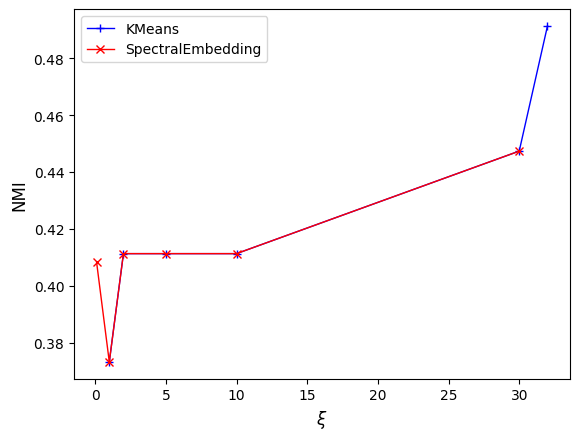

In [30]:
import matplotlib.pyplot as plt
plt.plot(alpha_list, nmi_si_list, linewidth=1, marker='+', color='blue', label='KMeans')
plt.plot(alpha_list_sp, nmi_si_list_sp, linewidth=1, marker='x', color='red', label='SpectralEmbedding')
plt.xlabel('$\\xi$', size='large')
plt.ylabel("NMI", size='large')
plt.legend()
plt.savefig('sdp_si_friendship.pdf')
plt.show()